In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
conn = sqlite3.connect('../redditPosts.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT subreddit FROM Posts GROUP BY subreddit ORDER BY (COUNT(id))''')
subreddits = list(map(lambda x: x[0], cur.fetchall()))

subreddits

['Superstonks',
 'finance',
 'options',
 'pennystocks',
 'GME',
 'CryptoCurrency',
 'dogecoin',
 'wallstreetbets']

In [4]:
conn = sqlite3.connect('../redditPosts.sqlite')
query = '''SELECT * FROM Posts P JOIN PostBodyAndScore B ON P.id = B.id 
           WHERE B.body != "[removed]" AND B.body != "[deleted]"'''
df = pd.read_sql(sql=query, con=conn)
df.head(2)

,id,subreddit,title,author,url,created,ext_link,id,body,score,upvote_ratio
0,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,,1,1.0
1,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,,1,1.0


In [5]:
df.shape

(226890, 11)

## Selecting subreddit with complete datasets

In [6]:
df = df[(df.subreddit == 'Superstonks') |
        (df.subreddit == 'finance') |
        (df.subreddit == 'options') |
        (df.subreddit == 'pennystocks') |
        (df.subreddit == 'GME')]

## Plot the histogram of score for each subreddit

finance 1.0 1.0 240.2
options 0.0 1.0 44.0
pennystocks 1.0 4.0 154.0
Superstonks 1.0 7.0 29.1
GME 0.0 12.0 465.0


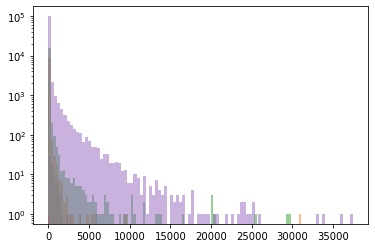

In [7]:
for sr in df.subreddit.unique():
    scores = df[df.subreddit == sr].score.values
    plt.hist(scores, 100, alpha=0.5)
    print(sr, '%.1f %.1f %.1f' % (np.percentile(scores, 5), np.percentile(scores, 50), np.percentile(scores, 95)))
plt.yscale('log')
plt.show()

## Defining the popular posts for binary classification

In [8]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [9]:
df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

<ipython-input-9-c9e97835cf12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_superstocks['popular'] = 0
<ipython-input-9-c9e97835cf12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finance['popular'] = 0
<ipython-input-9-c9e97835cf12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [10]:
df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

/Users/dutomo/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
del df
#df = pd.concat([df_superstocks, df_finance, df_options, df_pennystocks, df_gme], ignore_index=True)
df = df_gme
df.head(2)

,id,subreddit,title,author,url,created,ext_link,id,body,score,upvote_ratio,popular
27514,kqfajb,GME,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,1609786946,https://www.reddit.com/r/GME/comments/kqfajb/y...,kqfajb,After watching this I took a position RIGHT AW...,6,0.61,0
27515,kqvp7l,GME,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1609841999,https://www.reddit.com/r/GME/comments/kqvp7l/t...,kqvp7l,This guy explained exactly how to take a posit...,2,0.56,0


In [12]:
df.popular.unique()

array([0, 1])

## Dropping unnecessary columns

In [13]:
df.drop(['id','url'], axis=1, inplace=True)
df.head()

,subreddit,title,author,created,ext_link,body,score,upvote_ratio,popular
27514,GME,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,1609786946,https://www.reddit.com/r/GME/comments/kqfajb/y...,After watching this I took a position RIGHT AW...,6,0.61,0
27515,GME,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,1609841999,https://www.reddit.com/r/GME/comments/kqvp7l/t...,This guy explained exactly how to take a posit...,2,0.56,0
27516,GME,ICR conference (11th Jan),nicky94,1609939549,https://www.reddit.com/r/GME/comments/krnthg/i...,Any speculation or ideas on what Gamestop migh...,14,0.94,0
27517,GME,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,1610315957,https://www.reddit.com/r/GME/comments/kuo3w1/g...,"After some downwards movement, I think everyb...",11,0.79,0
27518,GME,Ryan Cohen appointed to board!!!!?,nicky94,1610368592,https://news.gamestop.com/news-releases/news-r...,,18,0.95,0


## Transforming time info

In [14]:
df['posting_time'] = df['created'].apply(dt.datetime.fromtimestamp)
df.drop('created', axis=1, inplace=True)
df.head()

,subreddit,title,author,ext_link,body,score,upvote_ratio,popular,posting_time
27514,GME,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,After watching this I took a position RIGHT AW...,6,0.61,0,2021-01-04 14:02:26
27515,GME,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,This guy explained exactly how to take a posit...,2,0.56,0,2021-01-05 05:19:59
27516,GME,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,Any speculation or ideas on what Gamestop migh...,14,0.94,0,2021-01-06 08:25:49
27517,GME,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,"After some downwards movement, I think everyb...",11,0.79,0,2021-01-10 16:59:17
27518,GME,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,,18,0.95,0,2021-01-11 07:36:32


In [15]:
df['posting_year'] = df['posting_time'].dt.year
df['posting_month'] = df['posting_time'].dt.month
df['posting_date'] = df['posting_time'].dt.day

def to_hour(inp):
    return inp.hour + (inp.minute/60.) + (inp.second/3600.)

df['posting_hour'] = df['posting_time'].apply(to_hour)

In [16]:
df.head()

,subreddit,title,author,ext_link,body,score,upvote_ratio,popular,posting_time,posting_year,posting_month,posting_date,posting_hour
27514,GME,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,After watching this I took a position RIGHT AW...,6,0.61,0,2021-01-04 14:02:26,2021,1,4,14.040556
27515,GME,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,This guy explained exactly how to take a posit...,2,0.56,0,2021-01-05 05:19:59,2021,1,5,5.333056
27516,GME,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,Any speculation or ideas on what Gamestop migh...,14,0.94,0,2021-01-06 08:25:49,2021,1,6,8.430278
27517,GME,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,"After some downwards movement, I think everyb...",11,0.79,0,2021-01-10 16:59:17,2021,1,10,16.988056
27518,GME,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,,18,0.95,0,2021-01-11 07:36:32,2021,1,11,7.608889


In [17]:
def weekday(inp):
    return inp.weekday()

df['posting_day'] = df['posting_time'].apply(weekday)

In [18]:
df = pd.concat([df, pd.get_dummies(df.posting_day, prefix='posting_day', drop_first=True)], axis=1)
df.drop('posting_day', axis=1, inplace=True)

In [19]:
df.drop('posting_time', axis=1, inplace=True)
df.head()

,subreddit,title,author,ext_link,body,score,upvote_ratio,popular,posting_year,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6
27514,GME,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqfajb/y...,After watching this I took a position RIGHT AW...,6,0.61,0,2021,1,4,14.040556,0,0,0,0,0,0
27515,GME,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,https://www.reddit.com/r/GME/comments/kqvp7l/t...,This guy explained exactly how to take a posit...,2,0.56,0,2021,1,5,5.333056,1,0,0,0,0,0
27516,GME,ICR conference (11th Jan),nicky94,https://www.reddit.com/r/GME/comments/krnthg/i...,Any speculation or ideas on what Gamestop migh...,14,0.94,0,2021,1,6,8.430278,0,1,0,0,0,0
27517,GME,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,https://www.reddit.com/r/GME/comments/kuo3w1/g...,"After some downwards movement, I think everyb...",11,0.79,0,2021,1,10,16.988056,0,0,0,0,0,1
27518,GME,Ryan Cohen appointed to board!!!!?,nicky94,https://news.gamestop.com/news-releases/news-r...,,18,0.95,0,2021,1,11,7.608889,0,0,0,0,0,0


## Extracting the external link

In [20]:
image_file_formats = ['ai','bmp','gif','ico','jpg','jpeg','png','ps','psd','svg','tif','tiff']
video_file_formats = ['.3g2','3gp','avi','flv','h264','m4v','mkv','mov','mp4','mpg','mpeg','rm','swf','vob','wmv']

In [21]:
def get_ext_media(inp):
    if inp == None:
        last_term = 'None'
    else:
        last_term = inp.split('.')[-1]
        
    if (last_term in image_file_formats) or (last_term in video_file_formats):
        out = 1
    else:
        out = 0
    return out

df['ext_link_media'] = df['ext_link'].apply(get_ext_media)

In [22]:
def get_ext_web(inp):
    if inp == None:
        last_term = 'None'
    else:
        last_term = inp.split('.')[-1]

    if (last_term not in image_file_formats+video_file_formats) and (last_term != 'None'):
        out = 1
    else:
        out = 0
    return out

df['ext_link_web'] = df['ext_link'].apply(get_ext_web)

In [23]:
df.drop('ext_link', axis=1, inplace=True)

In [24]:
df.head(2)

,subreddit,title,author,body,score,upvote_ratio,popular,posting_year,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,ext_link_web
27514,GME,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,After watching this I took a position RIGHT AW...,6,0.61,0,2021,1,4,14.040556,0,0,0,0,0,0,0,1
27515,GME,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,This guy explained exactly how to take a posit...,2,0.56,0,2021,1,5,5.333056,1,0,0,0,0,0,0,1


## Making one-hot-encoding from subreddit forum

In [25]:
df = pd.concat([df, pd.get_dummies(df.subreddit, prefix='subreddit', drop_first=True)], axis=1)
df.drop('subreddit', axis=1, inplace=True)

In [26]:
df.head(2)

,title,author,body,score,upvote_ratio,popular,posting_year,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,ext_link_web
27514,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,After watching this I took a position RIGHT AW...,6,0.61,0,2021,1,4,14.040556,0,0,0,0,0,0,0,1
27515,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,This guy explained exactly how to take a posit...,2,0.56,0,2021,1,5,5.333056,1,0,0,0,0,0,0,1


## Calculate the length of text

In [27]:
tokenizer = TweetTokenizer()
df['tokens_title'] = df['title'].str.lower().apply(tokenizer.tokenize)
df['tokens_body'] = df['body'].str.lower().apply(tokenizer.tokenize)
df['title_length'] = df['tokens_title'].apply(len)
df['body_length'] = df['tokens_body'].apply(len)

In [28]:
df.head(2)

,title,author,body,score,upvote_ratio,popular,posting_year,posting_month,posting_date,posting_hour,...,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,ext_link_web,tokens_title,tokens_body,title_length,body_length
27514,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,After watching this I took a position RIGHT AW...,6,0.61,0,2021,1,4,14.040556,...,0,0,0,0,0,1,"[you, need, to, see, this, about, gme, 🚀, 🚀, 🚀]","[after, watching, this, i, took, a, position, ...",10,11
27515,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,This guy explained exactly how to take a posit...,2,0.56,0,2021,1,5,5.333056,...,0,0,0,0,0,1,"[this, convinced, me, to, all, in, 💰, gme, (, ...","[this, guy, explained, exactly, how, to, take,...",13,22


## Other text attributes

In [29]:
import string
import re

def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def countUpper(text):
    Up = 0
    Low = 0
    for ch in text:
        if ch.isupper():
            Up += 1
        elif ch.islower():
            Low += 1
    
    if Up + Low:
        return Up/(Up+Low)
    else:
        return 0
    
def exclamationAndQuestion(text):
    return text.count('!') + text.count('?')

In [30]:
df['title_emoji'] = df['title'].apply(emoji_count)
df['body_emoji']  = df['body'].apply(emoji_count)
df['title_EQ']    = df['title'].apply(exclamationAndQuestion)
df['body_EQ']     = df['body'].apply(exclamationAndQuestion)
df['title_UL']    = df['title'].apply(countUpper)
df['body_UL']     = df['body'].apply(countUpper)

## Extract author information

In [31]:
author_scores = df.groupby('author').score.mean()
author_scores.head()

author
-----fish-----        1.0
--GoldenFire--       27.0
--GrinAndBearIt--    10.0
--Warmonger--         1.0
--sup                 2.0
Name: score, dtype: float64

In [32]:
author_scores['[deleted]']

12.298245614035087

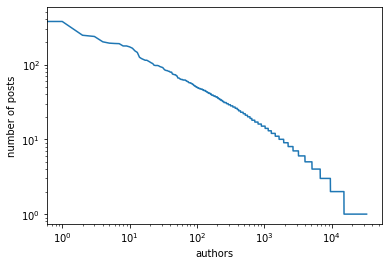

In [33]:
num_post_per_author = df['author'].value_counts().values
plt.plot(range(len(num_post_per_author)), num_post_per_author)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of posts')
plt.xlabel('authors')
plt.show()

In [34]:
author_posts = df['author'].value_counts()
author_posts.head()

Financial_Green9120    439
nmstanley32            376
BatSoup7519            246
tiptoeintotown         237
Several_Meet_8653      201
Name: author, dtype: int64

In [35]:
def log_num_posts(author):
    return np.log10(author_posts[author])

df['log_num_posts'] = df['author'].apply(log_num_posts)

In [36]:
def mean_scores(author):
    return author_scores[author]

df['mean_scores'] = df['author'].apply(mean_scores)

In [37]:
df.head(5)

,title,author,body,score,upvote_ratio,popular,posting_year,posting_month,posting_date,posting_hour,...,title_length,body_length,title_emoji,body_emoji,title_EQ,body_EQ,title_UL,body_UL,log_num_posts,mean_scores
27514,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,TitsDownOnly,After watching this I took a position RIGHT AW...,6,0.61,0,2021,1,4,14.040556,...,10,11,6,3,0,0,0.333333,0.278689,1.079181,121.083333
27515,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,TitsDownOnly,This guy explained exactly how to take a posit...,2,0.56,0,2021,1,5,5.333056,...,13,22,1,11,0,2,1.000000,0.105691,1.079181,121.083333
27516,ICR conference (11th Jan),nicky94,Any speculation or ideas on what Gamestop migh...,14,0.94,0,2021,1,6,8.430278,...,6,94,0,1,0,2,0.222222,0.048387,0.698970,22.800000
27517,"GME is FINALLY going to the moon, this technic...",TitsDownOnly,"After some downwards movement, I think everyb...",11,0.79,0,2021,1,10,16.988056,...,17,54,3,5,0,1,0.166667,0.040724,1.079181,121.083333
27518,Ryan Cohen appointed to board!!!!?,nicky94,,18,0.95,0,2021,1,11,7.608889,...,9,0,0,0,5,0,0.080000,0.000000,0.698970,22.800000


# Splitting Data into train and test set

In [38]:
from sklearn.model_selection import train_test_split

X = df.drop(['popular', 'author', 'score', 'upvote_ratio', 'posting_year', 'tokens_title', 'tokens_body', 'title', 
             'body'], axis=1)
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [39]:
len(y_train[y_train == 1])/len(X_train)

0.04997272490097953

In [40]:
len(y_test[y_test == 1])/len(X_test)

0.04994782278721184

## Checking the variance of the data

In [41]:
X_train.describe()

,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,...,title_length,body_length,title_emoji,body_emoji,title_EQ,body_EQ,title_UL,body_UL,log_num_posts,mean_scores
count,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000,84326.00000,84326.000000,84326.000000,84326.000000,84326.000000,...,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000,84326.000000
mean,2.968598,15.335626,13.084162,0.158077,0.216197,0.19497,0.134371,0.076928,0.074698,0.312430,...,13.347034,65.973911,0.994332,4.524310,0.603230,0.888018,0.184422,0.040315,0.834534,136.978121
std,0.930791,9.251342,5.657647,0.364815,0.411652,0.39618,0.341053,0.266478,0.262905,0.463487,...,11.566928,247.811900,2.943378,73.729006,1.336158,4.110146,0.264252,0.111492,0.608830,442.396375
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,9.582847,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042857,0.000000,0.301030,11.000000
50%,3.000000,14.000000,13.176111,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.778151,28.000000
75%,4.000000,24.000000,17.115000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,17.000000,44.000000,1.000000,2.000000,1.000000,1.000000,0.179487,0.043956,1.230449,100.363636
max,5.000000,31.000000,23.998889,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,163.000000,14410.000000,167.000000,20060.000000,96.000000,532.000000,1.000000,1.000000,2.642465,37396.000000


## Scaling the continuum features

In [42]:
X_train.columns

Index(['posting_month', 'posting_date', 'posting_hour', 'posting_day_1',
       'posting_day_2', 'posting_day_3', 'posting_day_4', 'posting_day_5',
       'posting_day_6', 'ext_link_media', 'ext_link_web', 'title_length',
       'body_length', 'title_emoji', 'body_emoji', 'title_EQ', 'body_EQ',
       'title_UL', 'body_UL', 'log_num_posts', 'mean_scores'],
      dtype='object')

In [43]:
from sklearn.preprocessing import StandardScaler

scaled_cols = ['posting_month','posting_date','posting_hour','title_length','body_length','title_emoji',
               'body_emoji','title_EQ','body_EQ','title_UL','body_UL','mean_scores']

for col in scaled_cols:

    scaler = StandardScaler()

    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
    X_test[col]  = scaler.transform(X_test[col].values.reshape(-1,1))

<ipython-input-43-42341c9e48e8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
<ipython-input-43-42341c9e48e8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col]  = scaler.transform(X_test[col].values.reshape(-1,1))
<ipython-input-43-42341c9e48e8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [44]:
X_train.describe()

,posting_month,posting_date,posting_hour,posting_day_1,posting_day_2,posting_day_3,posting_day_4,posting_day_5,posting_day_6,ext_link_media,...,title_length,body_length,title_emoji,body_emoji,title_EQ,body_EQ,title_UL,body_UL,log_num_posts,mean_scores
count,8.432600e+04,8.432600e+04,8.432600e+04,84326.000000,84326.000000,84326.00000,84326.000000,84326.000000,84326.000000,84326.000000,...,8.432600e+04,8.432600e+04,8.432600e+04,8.432600e+04,8.432600e+04,8.432600e+04,8.432600e+04,8.432600e+04,84326.000000,8.432600e+04
mean,1.203464e-16,8.030112e-17,2.128022e-16,0.158077,0.216197,0.19497,0.134371,0.076928,0.074698,0.312430,...,2.746922e-17,1.643097e-17,-1.280773e-17,8.447206e-18,-1.845325e-17,-1.693654e-17,3.185081e-17,6.547111e-17,0.834534,-6.740913e-19
std,1.000006e+00,1.000006e+00,1.000006e+00,0.364815,0.411652,0.39618,0.341053,0.266478,0.262905,0.463487,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.608830,1.000006e+00
min,-2.114985e+00,-1.549582e+00,-2.312665e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,-1.067449e+00,-2.662273e-01,-3.378219e-01,-6.136441e-02,-4.514691e-01,-2.160564e-01,-6.979056e-01,-3.615946e-01,0.000000,-3.096294e-01
25%,-1.040624e+00,-7.929303e-01,-6.188678e-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,-6.351797e-01,-2.662273e-01,-3.378219e-01,-6.136441e-02,-4.514691e-01,-2.160564e-01,-5.357218e-01,-3.615946e-01,0.301030,-2.847647e-01
50%,3.373702e-02,-1.443719e-01,1.625225e-02,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,-2.893641e-01,-2.662273e-01,-3.378219e-01,-6.136441e-02,-4.514691e-01,-2.160564e-01,-3.825482e-01,-3.615946e-01,0.778151,-2.463374e-01
75%,1.108098e+00,9.365588e-01,7.124626e-01,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,3.158131e-01,-8.867226e-02,1.925852e-03,-3.423789e-02,2.969500e-01,2.724544e-02,-1.867428e-02,3.266062e-02,1.230449,-8.276447e-02
max,2.182459e+00,1.693210e+00,1.929210e+00,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.293808e+01,5.788306e+01,5.640005e+01,2.720177e+02,7.139677e+01,1.292205e+02,3.086383e+00,8.607712e+00,2.642465,8.422140e+01


# Modeling

## Logistic Regression

In [45]:
logreg = LogisticRegression(max_iter=10000, solver='liblinear', class_weight='balanced')
param_grid = {'C': [0.01,0.1,1,10],
              'penalty': ['l1','l2']}
gs = GridSearchCV(logreg, param_grid=param_grid) #, scoring='f1')
gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [46]:
gs.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [47]:
gs.best_score_

0.8718307276810439

In [48]:
y_pred = gs.predict(X_train)
precision_recall_fscore_support(y_train, y_pred)

(array([0.98662602, 0.24819295]),
 array([0.87666018, 0.77408638]),
 array([0.92839816, 0.37587141]),
 array([80112,  4214]))

In [49]:
y_pred = gs.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

(array([0.98552189, 0.24371551]),
 array([0.8768286 , 0.75498575]),
 array([0.92800338, 0.36848204]),
 array([20029,  1053]))

In [50]:
confusion_matrix(y_test, y_pred)

array([[17562,  2467],
       [  258,   795]])

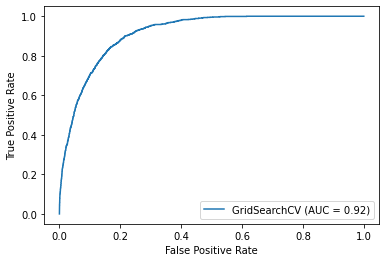

In [51]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(gs, X_test, y_test)

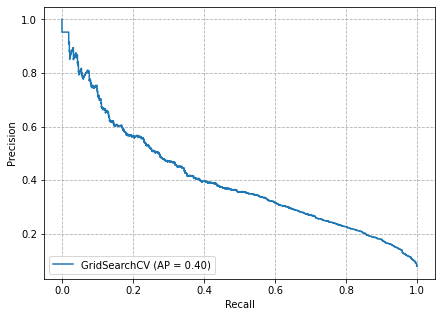

In [52]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(gs, X_test, y_test, ax=ax)
plt.grid(ls='--')
plt.savefig('../../plots/prec_rec_curve_logreg.png')

In [53]:
y_prob = gs.predict_proba(X_test)[:,1]
precision_recall_fscore_support(y_test, 1*(y_prob > 0.9))

(array([0.96681383, 0.41603467]),
 array([0.97308902, 0.36467236]),
 array([0.96994128, 0.38866397]),
 array([20029,  1053]))

In [54]:
from joblib import dump, load
dump(gs, '../../saved_models/logreg.joblib')

['../../saved_models/logreg.joblib']

## Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 20]}

gs_rf = GridSearchCV(rfc, param_grid=param_grid)

gs_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20]})

In [56]:
gs_rf.best_params_

{'max_depth': 20}

In [57]:
y_pred = gs_rf.predict(X_train)
precision_recall_fscore_support(y_train, y_pred)

(array([0.99367418, 1.        ]),
 array([1.        , 0.87897485]),
 array([0.99682706, 0.9355898 ]),
 array([80112,  4214]))

In [58]:
y_pred = gs_rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

(array([0.96160154, 0.73011364]),
 array([0.99525688, 0.24406458]),
 array([0.9781398, 0.3658363]),
 array([20029,  1053]))

In [59]:
confusion_matrix(y_test, y_pred)

array([[19934,    95],
       [  796,   257]])

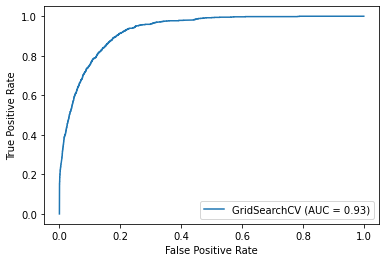

In [60]:
plot_roc_curve(gs_rf, X_test, y_test)

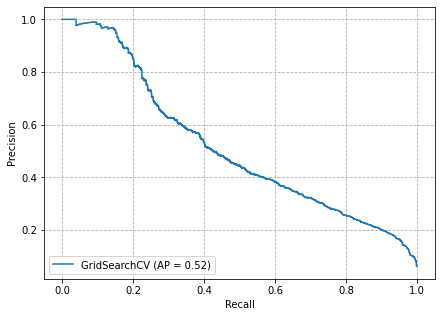

In [61]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(gs_rf, X_test, y_test, ax=ax)
plt.grid(ls='--')

In [62]:
y_prob = gs.predict_proba(X_test)[:,1]
precision_recall_fscore_support(y_test, 1*(y_prob > 0.8))

(array([0.97191097, 0.36718175]),
 array([0.95706226, 0.47388414]),
 array([0.96442946, 0.41376451]),
 array([20029,  1053]))

In [63]:
dump(gs_rf, '../../saved_models/rfc.joblib')

['../../saved_models/rfc.joblib']

## XGBoost

In [64]:
from xgboost import XGBClassifier

xgb = XGBClassifier(verbosity=0)

param_grid = {'max_depth': [4, 5, 6],
              'alpha': [1, 10, 100]}

gs_xgb = GridSearchCV(xgb, param_grid=param_grid)

gs_xgb.fit(X_train, y_train)

/Users/dutomo/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [65]:
gs_xgb.best_params_

{'alpha': 10, 'max_depth': 4}

In [66]:
y_pred = gs_xgb.predict(X_train)
precision_recall_fscore_support(y_train, y_pred)

(array([0.96643848, 0.80625349]),
 array([0.99566856, 0.3426673 ]),
 array([0.9808358 , 0.48093256]),
 array([80112,  4214]))

In [67]:
y_pred = gs_xgb.predict(X_test)
precision_recall_fscore_support(y_test, y_pred)

(array([0.9635994 , 0.71158392]),
 array([0.99390883, 0.28584995]),
 array([0.97851947, 0.40785908]),
 array([20029,  1053]))

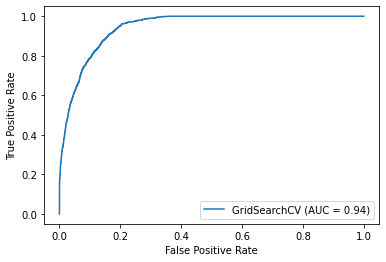

In [68]:
plot_roc_curve(gs_xgb, X_test, y_test)

## Neural network

In [69]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy, Recall, BinaryAccuracy

In [70]:
def build_network(n_features, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0.):
    ''' Building neural network model '''
    model = Sequential()
    model.add(Dense(n_nodes, activation=activ_func, use_bias=True, input_shape=(n_features,)))
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=activ_func, use_bias=True))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, input_shape=(n_nodes,)))
    model.add(Dense(n_output, activation='sigmoid'))
    return model

In [71]:
def fit_network(X, y, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0., epochs=10,
                metrics=[binary_accuracy], loss_weights=None, patience=5):
    # Building neural network model
    n_features = np.shape(X)[1]
    model = build_network(n_features, n_output, n_layers, n_nodes, activ_func, dropout_rate)
    # Compiling model
    early_stopping_monitor = EarlyStopping(patience=patience)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics, loss_weights=loss_weights)
    # Fitting model
    history = model.fit(X, y,
                        validation_split=0.2, epochs=epochs,
                        shuffle=True, callbacks=[early_stopping_monitor])
    return model, history

In [72]:
model, history = fit_network(X_train, y_train, n_output=1, n_layers=2, n_nodes=10, epochs=10, patience=3)

Epoch 1/10
2109/2109 [==============================] - 2s 990us/step - loss: 0.2273 - binary_accuracy: 0.9321 - val_loss: 0.1250 - val_binary_accuracy: 0.9545
Epoch 2/10
2109/2109 [==============================] - 1s 706us/step - loss: 0.1262 - binary_accuracy: 0.9537 - val_loss: 0.1196 - val_binary_accuracy: 0.9546
Epoch 3/10
2109/2109 [==============================] - 2s 815us/step - loss: 0.1205 - binary_accuracy: 0.9541 - val_loss: 0.1158 - val_binary_accuracy: 0.9561
Epoch 4/10
2109/2109 [==============================] - 2s 790us/step - loss: 0.1150 - binary_accuracy: 0.9557 - val_loss: 0.1137 - val_binary_accuracy: 0.9567
Epoch 5/10
2109/2109 [==============================] - 2s 926us/step - loss: 0.1152 - binary_accuracy: 0.9541 - val_loss: 0.1129 - val_binary_accuracy: 0.9564
Epoch 6/10
2109/2109 [==============================] - 2s 945us/step - loss: 0.1098 - binary_accuracy: 0.9570 - val_loss: 0.1128 - val_binary_accuracy: 0.9575
Epoch 7/10
2109/2109 [==================

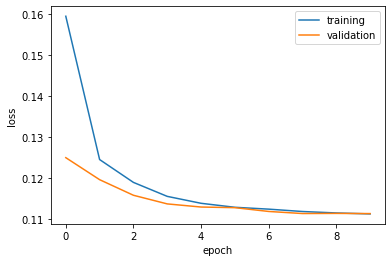

In [73]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [74]:
y_prob = model.predict(X_train)
precision_recall_fscore_support(y_train, 1*(y_prob > 0.5))

(array([0.96082991, 0.72460497]),
 array([0.9954314 , 0.22852397]),
 array([0.97782464, 0.34746527]),
 array([80112,  4214]))

In [75]:
y_prob = model.predict(X_test)
precision_recall_fscore_support(y_test, 1*(y_prob > 0.5))

(array([0.95911103, 0.69047619]),
 array([0.99545659, 0.19278253]),
 array([0.97694588, 0.30141054]),
 array([20029,  1053]))

In [76]:
from sklearn.metrics import precision_score, recall_score

thres = np.arange(0,1,0.01)

prec_nn = []
rec_nn = []

for t in thres:
    prec_nn.append(precision_score(y_test, 1*(y_prob > t)))
    rec_nn.append(recall_score(y_test, 1*(y_prob > t)))

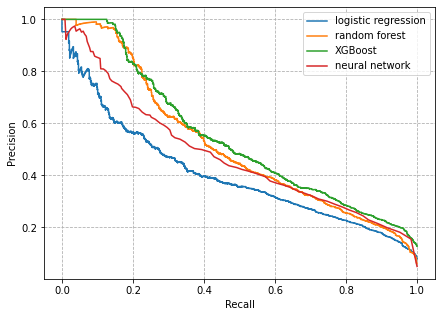

In [77]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plot_precision_recall_curve(gs, X_test, y_test, ax=ax, label='logistic regression')
plot_precision_recall_curve(gs_rf, X_test, y_test, ax=ax, label='random forest')
plot_precision_recall_curve(gs_xgb, X_test, y_test, ax=ax, label='XGBoost')
ax.plot(rec_nn, prec_nn, label='neural network')
plt.grid(ls='--')
plt.legend(loc='upper right')
plt.savefig('../../plots/prec_rec_curve.png')